<a href="https://colab.research.google.com/github/ccstevie/nhl_model/blob/main/model2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data preprocessing

In [1]:
import pandas as pd

Natural Stat Trick doesn't let you view more than 5 seasons at once, so we need to manually gather 10 seasons of data

In [2]:
dfH = pd.read_csv("home_games.csv")

In [3]:
dfH.shape

(13129, 33)

In [4]:
dfA = pd.read_csv("away_games.csv")

In [5]:
dfA.shape

(13129, 33)

In [6]:
dfH.drop(columns=["Unnamed: 2", "TOI", "GF%", "PDO", "SH%", "SV%", "CF", "CA", "FF", 
                  "FA", "SF", "SA", "xGA", "SCF", "SCA", "HDCF", "HDCA", "HDGF", "HDGA"], inplace=True)

In [7]:
dfH.head(1)

,Game,Team,CF%,FF%,SF%,GF,GA,xGF,xGF%,SCF%,HDCF%,HDGF%,HDSH%,HDSV%
0,"2013-10-01 - Maple Leafs 4, Canadiens 3",Montreal Canadiens,58.95,62.86,60.42,2,2,2.42,62.77,57.89,76.47,66.67,20.00,66.67


In [8]:
dfA.drop(columns=["Unnamed: 2", "Game", "TOI", "GF%", "PDO", "SH%", "SV%", "CF", "CA", "FF", 
                  "FA", "SF", "SA", "xGA", "SCF", "SCA", "HDCF", "HDCA", "HDGF", "HDGA"], inplace=True)
dfA = dfA.add_prefix("Opp ")

In [9]:
dfA.head(1)

,Opp Team,Opp CF%,Opp FF%,Opp SF%,Opp GF,Opp GA,Opp xGF,Opp xGF%,Opp SCF%,Opp HDCF%,Opp HDGF%,Opp HDSH%,Opp HDSV%
0,Toronto Maple Leafs,41.05,37.14,39.58,2,2,1.43,37.23,42.11,23.53,33.33,33.33,80.00


In [10]:
# Merge home and array games to obtain matchup table
df = pd.merge(dfH, dfA, left_index=True, right_index=True)

In [11]:
df.dropna(inplace=True)

In [12]:
df["Home/Away"] = 100

In [13]:
dfA = pd.read_csv("away_games.csv")
dfA.drop(columns=["Unnamed: 2", "TOI", "GF%", "PDO", "SH%", "SV%", "CF", "CA", "FF", 
                  "FA", "SF", "SA", "xGA", "SCF", "SCA", "HDCF", "HDCA", "HDGF", "HDGA"], inplace=True)

In [14]:
dfH.drop(columns=["Game"], inplace=True)
dfH = dfH.add_prefix("Opp ")

In [15]:
# Merge home and array games to obtain matchup table
df_away = pd.merge(dfA, dfH, left_index=True, right_index=True)

In [16]:
# Drop unused columns
df_away.dropna(inplace=True)

In [17]:
df_away["Home/Away"] = 0

In [18]:
df = pd.concat([df, df_away], ignore_index=True)
df.replace('-', pd.NA, inplace=True)
df.dropna(inplace=True)

In [19]:
# Change "Game" column to Date
df["Game"] = df["Game"].str.split(" - ").str[0]
df.rename(columns={'Game': 'Date'}, inplace=True)
# Convert 'Date' column from string to datetime
df['Date'] = pd.to_datetime(df['Date'])

Group by team and shift previous game to see if they were home or away and who they faced (for distance calculation)

In [20]:
# Sort the DataFrame by team and date
df.sort_values(by=['Team', 'Date'], inplace=True)

# Shift the 'Home/Away' column to get the previous game's location
df['Last Location'] = df.groupby('Team')['Home/Away'].shift()

# Shift the 'Opp Team' column to get the team they last faced
df['Last Opp Team'] = df.groupby('Team')['Opp Team'].shift()

# Drop the first row for each team as it won't have a previous game
df.dropna(subset=['Last Location', 'Last Opp Team'], inplace=True)

In [21]:
df

,Date,Team,CF%,FF%,SF%,GF,GA,xGF,xGF%,SCF%,...,Opp xGF,Opp xGF%,Opp SCF%,Opp HDCF%,Opp HDGF%,Opp HDSH%,Opp HDSV%,Home/Away,Last Location,Last Opp Team
13157,2013-10-05,Anaheim Ducks,33.77,37.93,40.48,2,1,1.01,25.02,28.57,...,3.01,74.98,71.43,68.18,50.00,10.00,83.33,0,0.0,Colorado Avalanche
13161,2013-10-06,Anaheim Ducks,58.54,63.33,65.12,2,1,2.56,68.55,61.36,...,1.17,31.45,38.64,36.84,0.00,0.00,81.82,0,0.0,Minnesota Wild
56,2013-10-10,Anaheim Ducks,45.12,48.44,47.27,6,0,1.58,44.61,47.62,...,1.96,55.39,52.38,60.00,0.00,0.00,42.86,100,0.0,Winnipeg Jets
77,2013-10-13,Anaheim Ducks,50.00,56.04,57.58,4,1,3.59,57.97,52.38,...,2.60,42.03,47.62,46.43,25.00,9.09,78.57,100,100.0,New York Rangers
94,2013-10-16,Anaheim Ducks,42.67,36.84,34.15,3,1,1.34,38.62,50.00,...,2.13,61.38,50.00,52.38,25.00,10.00,57.14,100,100.0,Ottawa Senators
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26182,2024-03-09,Winnipeg Jets,41.76,40.00,38.89,0,4,2.04,40.33,34.78,...,3.01,59.67,65.22,68.00,100.00,23.08,100.00,0,0.0,Seattle Kraken
13063,2024-03-11,Winnipeg Jets,60.91,63.29,57.14,3,0,3.17,64.49,55.56,...,1.75,35.51,44.44,22.73,0.00,0.00,81.82,100,0.0,Vancouver Canucks
13076,2024-03-13,Winnipeg Jets,39.78,40.00,36.36,1,4,1.23,30.90,33.33,...,2.75,69.10,66.67,72.73,50.00,9.09,50.00,100,100.0,Washington Capitals
26238,2024-03-17,Winnipeg Jets,43.75,49.23,51.02,6,1,2.41,61.46,45.65,...,1.51,38.54,54.35,42.11,33.33,33.33,75.00,0,100.0,Nashville Predators


In [22]:
drop = ["Game", "Team", "Opp Team", "GF", "GA", "Opp GF", "Opp GA", "xGF", "Opp xGF", "Last Opp Team"]

for col in df:
    if col not in drop:
        try:
            df[col] = df[col].astype(float)
            df[col] = df[col] / 100.0
        except:
            continue
df.head(1)

,Date,Team,CF%,FF%,SF%,GF,GA,xGF,xGF%,SCF%,...,Opp xGF,Opp xGF%,Opp SCF%,Opp HDCF%,Opp HDGF%,Opp HDSH%,Opp HDSV%,Home/Away,Last Location,Last Opp Team
13157,2013-10-05,Anaheim Ducks,0.3377,0.3793,0.4048,2,1,1.01,0.2502,0.2857,...,3.01,0.7498,0.7143,0.6818,0.5,0.1,0.8333,0.0,0.0,Colorado Avalanche


1.5 Getting a team's schedule and travel distance and calculating rolling features

In [23]:
from stadium_locations import getLocations

stadium_locations = getLocations()
stadium_locations

{'Anaheim Ducks': (33.80737, -117.87663),
 'Arizona Coyotes': (33.4293114, -111.9293116),
 'Phoenix Coyotes': (33.4293114, -111.9293116),
 'Boston Bruins': (42.3662986, -71.0621622),
 'Buffalo Sabres': (43.001073, -78.745679),
 'Calgary Flames': (51.0374124, -114.0519642),
 'Carolina Hurricanes': (35.803398, -78.7219166),
 'Chicago Blackhawks': (41.8806831, -87.6741851),
 'Colorado Avalanche': (39.7486838, -105.007544),
 'Columbus Blue Jackets': (39.9691873, -83.00608),
 'Dallas Stars': (32.7905076, -96.8102721),
 'Detroit Red Wings': (42.3409774, -83.0549545),
 'Edmonton Oilers': (53.5467936, -113.4977946),
 'Florida Panthers': (26.145757, -80.298062),
 'Los Angeles Kings': (34.0429979, -118.2671352),
 'Minnesota Wild': (44.943388, -93.096483),
 'Montreal Canadiens': (45.50884, -73.58781),
 'Nashville Predators': (36.1598551, -86.7790511),
 'New Jersey Devils': (40.735155, -74.1691948),
 'New York Islanders': (40.714829, -73.722145),
 'New York Rangers': (40.7505129, -73.9935159),
 'O

In [24]:
from geopy.distance import geodesic

# Calculate distance traveled for each game
df['Distance Traveled'] = 0.0
df['Opp Distance Traveled'] = 0.0
for index, row in df.iterrows():
    opponent = row['Opp Team']
    if row["Last Location"] == 1:
        team = row['Team']
    else:
        team = row['Last Opp Team']
    start = stadium_locations[team]
    end = stadium_locations[opponent]
    distance = geodesic(start, end).kilometers
    if row['Home/Away'] == 1:
        df.at[index, 'Opp Distance Traveled'] = int(distance)
    else:
        df.at[index, 'Distance Traveled'] = int(distance)

In [25]:
df.head(10)

,Date,Team,CF%,FF%,SF%,GF,GA,xGF,xGF%,SCF%,...,Opp SCF%,Opp HDCF%,Opp HDGF%,Opp HDSH%,Opp HDSV%,Home/Away,Last Location,Last Opp Team,Distance Traveled,Opp Distance Traveled
13157,2013-10-05,Anaheim Ducks,0.3377,0.3793,0.4048,2,1,1.01,0.2502,0.2857,...,0.7143,0.6818,0.50,0.1000,0.8333,0.0,0.0,Colorado Avalanche,1136.0,0.0
13161,2013-10-06,Anaheim Ducks,0.5854,0.6333,0.6512,2,1,2.56,0.6855,0.6136,...,0.3864,0.3684,0.00,0.0000,0.8182,0.0,0.0,Minnesota Wild,629.0,0.0
56,2013-10-10,Anaheim Ducks,0.4512,0.4844,0.4727,6,0,1.58,0.4461,0.4762,...,0.5238,0.6000,0.00,0.0000,0.4286,1.0,0.0,Winnipeg Jets,0.0,2067.0
77,2013-10-13,Anaheim Ducks,0.5000,0.5604,0.5758,4,1,3.59,0.5797,0.5238,...,0.4762,0.4643,0.25,0.0909,0.7857,1.0,1.0,New York Rangers,0.0,3775.0
94,2013-10-16,Anaheim Ducks,0.4267,0.3684,0.3415,3,1,1.34,0.3862,0.5000,...,0.5000,0.5238,0.25,0.1000,0.5714,1.0,1.0,Ottawa Senators,0.0,1938.0
108,2013-10-18,Anaheim Ducks,0.5641,0.5179,0.5476,2,2,1.60,0.5651,0.5172,...,0.4828,0.5000,0.00,0.0000,0.7500,1.0,1.0,Calgary Flames,0.0,553.0
124,2013-10-20,Anaheim Ducks,0.4894,0.4930,0.5400,3,2,2.27,0.5690,0.5208,...,0.4792,0.4000,0.00,0.0000,0.7500,1.0,1.0,Phoenix Coyotes,0.0,1961.0
13257,2013-10-22,Anaheim Ducks,0.5904,0.5965,0.4706,2,3,1.63,0.5647,0.5676,...,0.4324,0.3636,0.50,0.2500,0.5000,0.0,1.0,Dallas Stars,3485.0,0.0
13270,2013-10-24,Anaheim Ducks,0.6024,0.6066,0.6444,1,2,1.95,0.5438,0.6286,...,0.3714,0.3500,0.50,0.1667,0.8571,0.0,0.0,Toronto Maple Leafs,504.0,0.0
13279,2013-10-25,Anaheim Ducks,0.5200,0.5439,0.5946,2,0,1.68,0.5661,0.5833,...,0.4167,0.5000,0.00,0.0000,0.8000,0.0,0.0,Montreal Canadiens,184.0,0.0


In [26]:
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)

In [27]:
df['Goals Above Expected'] = df['GF'] - df['xGF']
df['Opp Goals Above Expected'] = df['Opp GF'] - df['Opp xGF']
grouped_df = df.groupby("Team")
grouped_dfs = []

# Access each group separately
for team, team_df in grouped_df:
    team_df["Rolling Distance Traveled"] = team_df["Distance Traveled"].rolling("3D").sum()
    team_df["Opp Rolling Distance Traveled"] = team_df["Opp Distance Traveled"].rolling("3D").sum()
    team_df["Rolling GF"] = team_df["GF"].rolling(window=3, min_periods=1).sum()
    team_df["Opp Rolling GF"] = team_df["Opp GF"].rolling(window=3, min_periods=1).sum()
    team_df['Rolling Goals Above Expected'] = team_df['Goals Above Expected'].rolling(window=3, min_periods=1).sum()
    team_df['Opp Rolling Goals Above Expected'] = team_df['Opp Goals Above Expected'].rolling(window=3, min_periods=1).sum()

    grouped_dfs.append(team_df)

# Concatenate the list of grouped DataFrames
merged_df = pd.concat(grouped_dfs)

In [28]:
merged_df.drop(columns=["Goals Above Expected", "Opp Goals Above Expected"], inplace=True)

In [29]:
merged_df.sort_values("Date")

,Team,CF%,FF%,SF%,GF,GA,xGF,xGF%,SCF%,HDCF%,...,Last Location,Last Opp Team,Distance Traveled,Opp Distance Traveled,Rolling Distance Traveled,Opp Rolling Distance Traveled,Rolling GF,Opp Rolling GF,Rolling Goals Above Expected,Opp Rolling Goals Above Expected
Date,,,,,,,,,,,,,,,,,,,,,
2013-10-02,Toronto Maple Leafs,0.4286,0.4727,0.5526,2,0,1.16,0.4260,0.4118,0.3846,...,0.0,Montreal Canadiens,635.0,0.0,635.0,0.0,2.0,0.0,0.84,-1.56
2013-10-03,Washington Capitals,0.5612,0.5479,0.5091,2,2,2.18,0.4583,0.5667,0.3333,...,0.0,Chicago Blackhawks,0.0,2250.0,0.0,2250.0,2.0,2.0,-0.18,-0.58
2013-10-04,Colorado Avalanche,0.5875,0.6094,0.6327,2,1,1.91,0.6141,0.5897,0.7500,...,1.0,Anaheim Ducks,0.0,1647.0,0.0,1647.0,2.0,1.0,0.09,-0.20
2013-10-04,Winnipeg Jets,0.4598,0.4697,0.4583,3,1,1.91,0.4825,0.4762,0.5714,...,0.0,Edmonton Oilers,0.0,2199.0,0.0,2199.0,3.0,1.0,1.09,-1.05
2013-10-04,Nashville Predators,0.4125,0.3906,0.3673,1,2,1.20,0.3859,0.4103,0.2500,...,0.0,St Louis Blues,1283.0,0.0,1283.0,0.0,1.0,2.0,-0.20,0.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-19,Vancouver Canucks,0.5062,0.5769,0.6452,1,0,3.38,0.7669,0.6829,0.8421,...,1.0,Washington Capitals,0.0,3446.0,0.0,3446.0,5.0,4.0,-1.19,-2.22
2024-03-19,Vegas Golden Knights,0.6125,0.6364,0.5789,3,2,1.91,0.7301,0.6875,0.7143,...,1.0,New Jersey Devils,0.0,3204.0,0.0,6457.0,6.0,6.0,0.15,1.25
2024-03-19,Boston Bruins,0.5056,0.5167,0.5263,4,1,2.05,0.5499,0.5319,0.6316,...,1.0,Philadelphia Flyers,0.0,508.0,0.0,508.0,9.0,6.0,2.02,1.91


Machine Learning with Sci-kit Learn

(A) Generating Interactions

In [30]:
# # List of features for home team and away team
# home_features = ['CF%', 'FF%', 'SF%', 'xGF%', 'SCF%', 'HDCF%',
#                  'HDGF%', 'HDSH%', 'HDSV%']
# away_features = ['Opp CF%', 'Opp FF%', 'Opp SF%', 'Opp xGF%', 'Opp SCF%', 
#                  'Opp HDCF%', 'Opp HDGF%', 'Opp HDSH%', 'Opp HDSV%']

In [31]:
# from sklearn.preprocessing import PolynomialFeatures

# # Create interaction terms between home team statistics and the 'Home/Away' indicator
# poly_home = PolynomialFeatures(interaction_only=True, include_bias=False)
# X_poly_home = poly_home.fit_transform(merged_df[home_features + ['Home/Away']])

In [32]:
# # Create interaction terms between away team statistics and the 'Home/Away' indicator
# poly_away = PolynomialFeatures(interaction_only=True, include_bias=False)
# X_poly_away = poly_away.fit_transform(merged_df[away_features + ['Home/Away']])

In [33]:
# feature_names_home = poly_home.get_feature_names_out(home_features + ['Home/Away'])

In [34]:
# feature_names_away = poly_away.get_feature_names_out(away_features + ['Home/Away'])

In [35]:
# # Combine interaction terms with other features
# X_home = pd.DataFrame(X_poly_home, columns=feature_names_home)
# X_away = pd.DataFrame(X_poly_away, columns=feature_names_away)
# X = pd.concat([X_home, X_away], axis=1)

(B) Using only rolling features 

In [36]:
merged_df.columns

Index(['Team', 'CF%', 'FF%', 'SF%', 'GF', 'GA', 'xGF', 'xGF%', 'SCF%', 'HDCF%',
       'HDGF%', 'HDSH%', 'HDSV%', 'Opp Team', 'Opp CF%', 'Opp FF%', 'Opp SF%',
       'Opp GF', 'Opp GA', 'Opp xGF', 'Opp xGF%', 'Opp SCF%', 'Opp HDCF%',
       'Opp HDGF%', 'Opp HDSH%', 'Opp HDSV%', 'Home/Away', 'Last Location',
       'Last Opp Team', 'Distance Traveled', 'Opp Distance Traveled',
       'Rolling Distance Traveled', 'Opp Rolling Distance Traveled',
       'Rolling GF', 'Opp Rolling GF', 'Rolling Goals Above Expected',
       'Opp Rolling Goals Above Expected'],
      dtype='object')

In [37]:
X = merged_df.drop(["Team", "GF", "GA", "Opp GF", "Opp GA", "xGF", "Opp xGF", "Opp Team", "Last Location", "Last Opp Team"], axis=1)

In [38]:
X.head(1)

,CF%,FF%,SF%,xGF%,SCF%,HDCF%,HDGF%,HDSH%,HDSV%,Opp CF%,...,Opp HDSV%,Home/Away,Distance Traveled,Opp Distance Traveled,Rolling Distance Traveled,Opp Rolling Distance Traveled,Rolling GF,Opp Rolling GF,Rolling Goals Above Expected,Opp Rolling Goals Above Expected
Date,,,,,,,,,,,,,,,,,,,,,
2013-10-05,0.3377,0.3793,0.4048,0.2502,0.2857,0.3182,0.5,0.1667,0.9,0.6623,...,0.8333,0.0,1136.0,0.0,1136.0,0.0,2.0,1.0,0.99,-2.01


In [39]:
y = merged_df[["GF", "GA"]]
y

,GF,GA
Date,,
2013-10-05,2,1
2013-10-06,2,1
2013-10-10,6,0
2013-10-13,4,1
2013-10-16,3,1
...,...,...
2024-03-09,0,4
2024-03-11,3,0
2024-03-13,1,4


3. Training the model

In [40]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [41]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor

base_model = RandomForestRegressor(random_state=42)
model = MultiOutputRegressor(base_model)
model.fit(X_train, y_train)

MultiOutputRegressor(estimator=RandomForestRegressor(random_state=42))

In [42]:
# Extract individual estimators from MultiOutputRegressor
estimators = model.estimators_

# Iterate through each estimator and print its feature importances
for i, estimator in enumerate(estimators):
    print(f"Estimator {i+1} Feature Importances:")
    if isinstance(estimator, RandomForestRegressor):
        feature_importances = estimator.feature_importances_
        sorted_indices = feature_importances.argsort()[::-1]  # Sort indices in descending order
        for idx in sorted_indices[:10]:
            feature_name = X_train.columns[idx]
            importance = feature_importances[idx]
            print(f"{feature_name}: {importance}")
    else:
        print("Feature importances are not available for this estimator type.")

Estimator 1 Feature Importances:
Rolling GF: 0.2027104045804832
Opp HDGF%: 0.14291184316842354
Opp HDSV%: 0.11342562505278146
HDSH%: 0.08446102948501852
Rolling Goals Above Expected: 0.041033033320252925
HDGF%: 0.039790079811865726
Opp Rolling Goals Above Expected: 0.03511547985762104
Opp xGF%: 0.022639803061687707
xGF%: 0.02258197231802562
Opp Rolling Distance Traveled: 0.020795829295388448
Estimator 2 Feature Importances:
Opp Rolling GF: 0.1942649570124437
HDGF%: 0.1449766442351864
HDSV%: 0.14016319428565432
Opp HDSH%: 0.06380989448501988
Opp Rolling Goals Above Expected: 0.04101757438061341
Opp HDGF%: 0.040478440226279784
Rolling Goals Above Expected: 0.035926148418948436
Opp xGF%: 0.022828454939834934
xGF%: 0.022630854332218165
Rolling Distance Traveled: 0.020228693742764484


Correlation Matrix:
             Estimator_1  Estimator_2
Estimator_1     1.000000    -0.102161
Estimator_2    -0.102161     1.000000


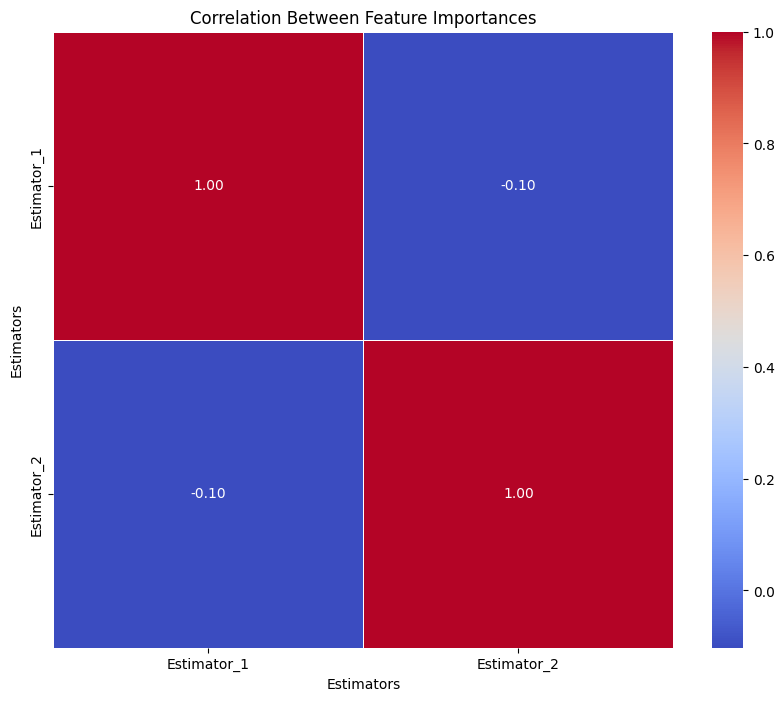

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have model as MultiOutputRegressor trained on your data
# Replace model with your actual trained model

# Extract individual estimators from MultiOutputRegressor
estimators = model.estimators_

# Initialize an empty DataFrame to store feature importances
feature_importances = pd.DataFrame()

# Iterate through each estimator and store its feature importances in the DataFrame
for i, estimator in enumerate(estimators):
    if isinstance(estimator, RandomForestRegressor):
        # Get feature importances for the current estimator
        importances = estimator.feature_importances_
        
        # Create a DataFrame with feature names and importances
        importances_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
        
        # Store the feature importances for the current estimator in the main DataFrame
        feature_importances[f'Estimator_{i+1}'] = importances_df['Importance'].values

# Calculate correlation matrix
correlation_matrix = feature_importances.corr()

# Print correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

# Plot correlation matrix as heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Between Feature Importances")
plt.xlabel("Estimators")
plt.ylabel("Estimators")
plt.show()

In [44]:
from sklearn.metrics import mean_squared_error
y_train_pred = model.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
print("Training Mean Squared Error:", train_mse)

y_test_pred = model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
print("Test Mean Squared Error:", test_mse)

Training Mean Squared Error: 0.11257852625265798
Test Mean Squared Error: 0.8109587985172264


In [45]:
from datetime import date, timedelta
import requests

# we will use the last 30 days as our data range
today = date.today()
print("Today's date:", today)
start = today - timedelta(days=30)
print("30 days ago:", start)

Today's date: 2024-04-23
30 days ago: 2024-03-24


In [46]:
url = f"https://www.naturalstattrick.com/teamtable.php?fromseason=20232024&thruseason=20232024&stype=2&sit=all&score=all&rate=n&team=all&loc=B&gpf=410&fd={start}&td={today}"
req = requests.get(url)
req.status_code

200

In [47]:
df2 = pd.read_html(url, header=0, index_col = 0, na_values=["-"])[0]

In [48]:
from get_todays_games import getGames

matchups = getGames()
matchups


[('Capitals', 'Rangers'),
 ('Lightning', 'Panthers'),
 ('Avalanche', 'Jets'),
 ('Predators', 'Canucks')]

In [49]:
res = pd.DataFrame()

for away, home in matchups:
    home_df = df2[df2["Team"].str.contains(home)]
    away_df = df2[df2["Team"].str.contains(away)]
    away_df = away_df.add_prefix('Opp ')
    home_df = home_df.reset_index(drop=True)
    away_df = away_df.reset_index(drop=True)
    matchup_df = pd.merge(home_df, away_df, left_index=True, right_index=True)
    matchup_df["Home/Away"] = 100
    res = pd.concat([res, matchup_df], ignore_index=True)

In [50]:
common_cols = [col for col in res.columns.intersection(merged_df.columns)]
matchups_df = res[common_cols]

In [51]:
matchups_df

,Team,CF%,FF%,SF%,GF,GA,xGF,xGF%,SCF%,HDCF%,...,Opp GF,Opp GA,Opp xGF,Opp xGF%,Opp SCF%,Opp HDCF%,Opp HDGF%,Opp HDSH%,Opp HDSV%,Home/Away
0,New York Rangers,54.40,53.79,52.97,40,35,38.91,56.13,53.29,54.62,...,29,35,37.95,48.48,49.31,48.33,48.57,19.77,82.52,100
1,Florida Panthers,57.65,55.37,54.66,40,28,42.60,56.66,58.09,58.53,...,44,34,38.17,50.30,51.13,51.58,54.29,20.21,82.80,100
2,Winnipeg Jets,48.74,49.80,49.86,41,29,36.94,53.61,49.13,52.30,...,40,45,36.29,46.46,52.92,51.45,41.30,19.00,75.68,100
3,Vancouver Canucks,53.39,52.93,52.03,30,34,36.16,53.37,55.27,56.93,...,37,42,41.38,50.91,51.30,54.84,54.29,16.24,83.33,100


In [52]:
drop = ["Team", "Opp Team", "GA", "GF", "xGF", "Opp xGF"]

# Convert percentage values to decimal form
for col in matchups_df:
    if col not in drop:
        try:
            matchups_df = matchups_df.copy()
            matchups_df[col] = matchups_df[col].astype(float) / 100.0
        except:
            continue

In [53]:
matchups_df

,Team,CF%,FF%,SF%,GF,GA,xGF,xGF%,SCF%,HDCF%,...,Opp GF,Opp GA,Opp xGF,Opp xGF%,Opp SCF%,Opp HDCF%,Opp HDGF%,Opp HDSH%,Opp HDSV%,Home/Away
0,New York Rangers,0.5440,0.5379,0.5297,40,35,38.91,0.5613,0.5329,0.5462,...,0.29,0.35,37.95,0.4848,0.4931,0.4833,0.4857,0.1977,0.8252,1.0
1,Florida Panthers,0.5765,0.5537,0.5466,40,28,42.60,0.5666,0.5809,0.5853,...,0.44,0.34,38.17,0.5030,0.5113,0.5158,0.5429,0.2021,0.8280,1.0
2,Winnipeg Jets,0.4874,0.4980,0.4986,41,29,36.94,0.5361,0.4913,0.5230,...,0.40,0.45,36.29,0.4646,0.5292,0.5145,0.4130,0.1900,0.7568,1.0
3,Vancouver Canucks,0.5339,0.5293,0.5203,30,34,36.16,0.5337,0.5527,0.5693,...,0.37,0.42,41.38,0.5091,0.5130,0.5484,0.5429,0.1624,0.8333,1.0


In [54]:
urlH = f"https://www.naturalstattrick.com/games.php?fromseason=20232024&thruseason=20232024&stype=2&sit=5v5&loc=H&team=All&rate=n"
reqH = requests.get(urlH)
reqH.status_code

200

In [55]:
urlA = f"https://www.naturalstattrick.com/games.php?fromseason=20232024&thruseason=20232024&stype=2&sit=5v5&loc=A&team=All&rate=n"
reqA = requests.get(urlA)
reqA.status_code

200

In [56]:
rolling_dfH = pd.read_html(urlH, header=0, na_values=["-"])[0]

In [57]:
rolling_dfH["Game"] = rolling_dfH["Game"].str.split(" - ").str[0]
rolling_dfH.rename(columns={"Game": "Date"}, inplace=True)

In [58]:
tmp = rolling_dfH["Date"]
common_cols = [col for col in rolling_dfH.columns.intersection(merged_df.columns)]
rolling_dfH = rolling_dfH[common_cols]
rolling_dfH["Date"] = tmp

In [59]:
rolling_dfA = pd.read_html(urlA, header=0, na_values=["-"])[0]
rolling_dfA["Game"] = rolling_dfA["Game"].str.split(" - ").str[0]
rolling_dfA.rename(columns={"Game": "Date"}, inplace=True)
common_cols = [col for col in rolling_dfA.columns.intersection(merged_df.columns)]
rolling_dfA = rolling_dfA[common_cols]
rolling_dfA = rolling_dfA.add_prefix("Opp ")

In [60]:
rolling_df = pd.concat([rolling_dfH, rolling_dfA], axis=1)

In [61]:
rolling_df["Home/Away"] = 1

In [62]:
rolling_dfA = pd.read_html(urlA, header=0, na_values=["-"])[0]
rolling_dfA["Game"] = rolling_dfA["Game"].str.split(" - ").str[0]
rolling_dfA.rename(columns={"Game": "Date"}, inplace=True)
tmp = rolling_dfA["Date"]
common_cols = [col for col in rolling_dfA.columns.intersection(merged_df.columns)]
rolling_dfA = rolling_dfA[common_cols]
rolling_dfA["Date"] = tmp

In [63]:
rolling_dfH = pd.read_html(urlH, header=0, na_values=["-"])[0]
rolling_dfH["Game"] = rolling_dfH["Game"].str.split(" - ").str[0]
rolling_dfH.rename(columns={"Game": "Date"}, inplace=True)
common_cols = [col for col in rolling_dfH.columns.intersection(merged_df.columns)]
rolling_dfH = rolling_dfH[common_cols]
rolling_dfH = rolling_dfH.add_prefix("Opp ")

In [64]:
rolling_df_away = pd.concat([rolling_dfA, rolling_dfH], axis=1)

In [65]:
rolling_df_away["Home/Away"] = 0

In [66]:
rolling_df_away.shape

(1312, 28)

In [67]:
rolling_df.shape

(1312, 28)

In [68]:
rolling_df = pd.concat([rolling_df, rolling_df_away], axis=0)

In [69]:
rolling_df.sort_values('Date', inplace=True)

In [70]:
rolling_df['Last Location'] = rolling_df.groupby('Team')['Home/Away'].shift()

rolling_df['Last Opp Team'] = rolling_df.groupby('Team')['Opp Team'].shift()

rolling_df.dropna(subset=['Last Location', 'Last Opp Team'], inplace=True)

rolling_df.reset_index(inplace=True, drop=True)

In [71]:
rolling_df['Distance Traveled'] = 0.0
for index, row in rolling_df.iterrows():
    if row["Last Location"] == 1:
        start = row['Team']
    else:
        start = row['Last Opp Team']
    if row["Home/Away"] == 1:
        end = row["Team"]
    else:
        end = row["Opp Team"]
    start_stadium = stadium_locations[start]
    end_stadium = stadium_locations[end]
    distance = geodesic(start_stadium, end_stadium).kilometers
    rolling_df.at[index, 'Distance Traveled'] = int(distance)

In [72]:
rolling_df[rolling_df["Team"] == "Washington Capitals"]

,Team,CF%,FF%,SF%,GF,GA,xGF,xGF%,SCF%,HDCF%,...,Opp xGF%,Opp SCF%,Opp HDCF%,Opp HDGF%,Opp HDSH%,Opp HDSV%,Home/Away,Last Location,Last Opp Team,Distance Traveled
39,Washington Capitals,41.67,40.63,37.50,2,1,1.34,34.93,47.62,28.57,...,65.07,52.38,71.43,0.00,0.00,75.00,1,1.0,Pittsburgh Penguins,0.0
64,Washington Capitals,45.98,46.55,46.34,1,5,2.17,58.80,54.55,69.23,...,41.20,45.45,30.77,66.67,100.00,85.71,0,1.0,Calgary Flames,716.0
110,Washington Capitals,47.83,49.18,52.38,1,1,2.64,52.74,45.45,44.44,...,47.26,54.55,55.56,50.00,14.29,83.33,0,0.0,Ottawa Senators,184.0
158,Washington Capitals,58.67,66.67,64.71,0,2,2.24,71.97,66.67,62.50,...,28.03,33.33,37.50,100.00,33.33,100.00,1,0.0,Montreal Canadiens,787.0
165,Washington Capitals,45.16,49.15,48.72,4,4,1.39,35.77,33.96,40.00,...,64.23,66.04,60.00,66.67,50.00,50.00,0,1.0,Toronto Maple Leafs,318.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2456,Washington Capitals,45.08,42.31,38.60,2,0,1.78,41.50,46.55,41.18,...,58.50,53.45,58.82,NaN,0.00,100.00,0,1.0,Ottawa Senators,637.0
2481,Washington Capitals,56.12,60.61,57.89,1,3,2.54,72.07,62.79,75.00,...,27.93,37.21,25.00,50.00,50.00,85.71,0,0.0,Detroit Red Wings,360.0
2511,Washington Capitals,48.91,45.45,46.30,3,2,2.04,52.12,51.16,64.29,...,47.88,48.84,35.71,25.00,25.00,62.50,1,0.0,Buffalo Sabres,478.0
2550,Washington Capitals,58.14,63.49,60.53,1,0,2.66,74.81,59.46,66.67,...,25.19,40.54,33.33,NaN,0.00,100.00,1,1.0,Tampa Bay Lightning,0.0


In [73]:
rolling_df['Date'] = pd.to_datetime(rolling_df['Date'])
rolling_df.set_index('Date', inplace=True)
rolling_df.sort_index(inplace=True)

In [74]:
rolling_df['Goals Above Expected'] = rolling_df['GF'] - rolling_df['xGF']
rolling_df['Opp Goals Above Expected'] = rolling_df['Opp GF'] - rolling_df['Opp xGF']
grouped_df = rolling_df.groupby("Team")
grouped_dfs = []

for team, team_df in grouped_df:
    team_df["Rolling Distance Traveled"] = team_df["Distance Traveled"].rolling("2D").sum()
    team_df["Rolling GF"] = team_df["GF"].rolling(window=3, min_periods=1).sum()
    team_df["Opp Rolling GF"] = team_df["Opp GF"].rolling(window=3, min_periods=1).sum()
    team_df['Rolling Goals Above Expected'] = team_df['Goals Above Expected'].rolling(window=3, min_periods=1).sum()
    team_df['Opp Rolling Goals Above Expected'] = team_df['Opp Goals Above Expected'].rolling(window=3, min_periods=1).sum()

    grouped_dfs.append(team_df)

merged_df = pd.concat(grouped_dfs)

In [75]:
latest_df = merged_df.reset_index().sort_values(by='Date').groupby('Team').last()

In [76]:
latest_df = latest_df.reset_index()

In [77]:
latest_df

,Team,Date,CF%,FF%,SF%,GF,GA,xGF,xGF%,SCF%,...,Last Location,Last Opp Team,Distance Traveled,Goals Above Expected,Opp Goals Above Expected,Rolling Distance Traveled,Rolling GF,Opp Rolling GF,Rolling Goals Above Expected,Opp Rolling Goals Above Expected
0,Anaheim Ducks,2024-04-18,43.16,43.55,44.19,2,0,1.16,39.90,34.38,...,0.0,Los Angeles Kings,362.0,0.84,-1.74,362.0,5.0,4.0,0.56,-2.17
1,Arizona Coyotes,2024-04-17,37.50,39.13,43.48,3,2,1.20,34.64,38.46,...,0.0,Calgary Flames,1963.0,1.80,-0.26,1963.0,9.0,9.0,2.97,1.07
2,Boston Bruins,2024-04-16,60.98,60.34,56.82,0,2,2.04,68.75,61.76,...,0.0,Washington Capitals,634.0,-2.04,1.07,941.0,4.0,5.0,-2.28,-0.58
3,Buffalo Sabres,2024-04-15,48.96,47.37,50.91,3,2,2.82,48.78,54.84,...,0.0,Florida Panthers,292.0,0.18,-0.96,292.0,7.0,4.0,2.32,-4.31
4,Calgary Flames,2024-04-18,58.56,59.76,70.21,5,0,2.96,64.32,60.78,...,0.0,Vancouver Canucks,675.0,2.04,-1.64,675.0,11.0,7.0,4.07,-0.22
5,Carolina Hurricanes,2024-04-16,56.32,59.09,53.33,2,6,2.51,56.06,57.78,...,0.0,Chicago Blackhawks,446.0,-0.51,4.03,446.0,5.0,9.0,-3.27,4.34
6,Chicago Blackhawks,2024-04-18,26.51,23.88,25.00,3,2,1.03,23.56,25.00,...,0.0,Vegas Golden Knights,362.0,1.97,-1.34,362.0,6.0,5.0,2.51,-4.55
7,Colorado Avalanche,2024-04-18,51.04,47.76,45.24,4,0,1.80,37.66,50.00,...,0.0,Vegas Golden Knights,980.0,2.20,-2.97,980.0,7.0,7.0,0.93,0.12
8,Columbus Blue Jackets,2024-04-16,43.68,40.91,46.67,6,2,1.97,43.94,42.22,...,0.0,Nashville Predators,536.0,4.03,-0.51,536.0,10.0,10.0,4.42,1.52
9,Dallas Stars,2024-04-17,61.90,61.54,58.33,1,1,3.55,74.23,70.59,...,1.0,Seattle Kraken,0.0,-2.55,-0.23,0.0,3.0,4.0,-4.06,-0.17


In [78]:
matchups_df

,Team,CF%,FF%,SF%,GF,GA,xGF,xGF%,SCF%,HDCF%,...,Opp GF,Opp GA,Opp xGF,Opp xGF%,Opp SCF%,Opp HDCF%,Opp HDGF%,Opp HDSH%,Opp HDSV%,Home/Away
0,New York Rangers,0.5440,0.5379,0.5297,40,35,38.91,0.5613,0.5329,0.5462,...,0.29,0.35,37.95,0.4848,0.4931,0.4833,0.4857,0.1977,0.8252,1.0
1,Florida Panthers,0.5765,0.5537,0.5466,40,28,42.60,0.5666,0.5809,0.5853,...,0.44,0.34,38.17,0.5030,0.5113,0.5158,0.5429,0.2021,0.8280,1.0
2,Winnipeg Jets,0.4874,0.4980,0.4986,41,29,36.94,0.5361,0.4913,0.5230,...,0.40,0.45,36.29,0.4646,0.5292,0.5145,0.4130,0.1900,0.7568,1.0
3,Vancouver Canucks,0.5339,0.5293,0.5203,30,34,36.16,0.5337,0.5527,0.5693,...,0.37,0.42,41.38,0.5091,0.5130,0.5484,0.5429,0.1624,0.8333,1.0


In [79]:
matchups_df['Distance Traveled'] = 0.0
matchups_df['Opp Distance Traveled'] = 0.0
for index, row in matchups_df.iterrows():
    home_team = row['Team']
    away_team = row['Opp Team']
    last_location = latest_df.loc[latest_df["Team"] == home_team, "Home/Away"].values[0]
    if last_location == 0:
        latest_stadium = latest_df.loc[latest_df["Team"] == home_team, "Opp Team"].values[0]
        start = stadium_locations[latest_stadium]
        end = stadium_locations[home_team]
        distance = geodesic(start, end).kilometers
        matchups_df.at[index, "Distance Traveled"] = int(distance)
    opp_last_location = latest_df.loc[latest_df["Team"] == away_team, "Home/Away"].values[0]
    if opp_last_location == 1:
        start = stadium_locations[away_team]
        end = stadium_locations[home_team]
    else:
        opp_latest_stadium = latest_df.loc[latest_df["Team"] == away_team, "Opp Team"].values[0]
        start = stadium_locations[opp_latest_stadium]
        end = stadium_locations[home_team]
    distance = geodesic(start, end).kilometers
    matchups_df.at[index, "Opp Distance Traveled"] = int(distance)
    matchups_df.at[index, "Rolling Distance Traveled"] = latest_df.loc[latest_df['Team'] == home_team, 'Rolling Distance Traveled'].iloc[0] + matchups_df.at[index, "Distance Traveled"]
    matchups_df.at[index, "Opp Rolling Distance Traveled"] = latest_df.loc[latest_df['Team'] == away_team, 'Rolling Distance Traveled'].iloc[0] + matchups_df.at[index, "Opp Distance Traveled"]
    matchups_df.at[index, "Rolling GF"] = latest_df.loc[latest_df['Team'] == home_team, 'Rolling GF'].iloc[0]
    matchups_df.at[index, "Opp Rolling GF"] = latest_df.loc[latest_df['Team'] == away_team, 'Opp Rolling GF'].iloc[0]
    matchups_df.at[index, 'Rolling Goals Above Expected'] = latest_df.loc[latest_df['Team'] == home_team, 'Rolling Goals Above Expected'].iloc[0]
    matchups_df.at[index, 'Opp Rolling Goals Above Expected'] = latest_df.loc[latest_df['Team'] == away_team, 'Opp Rolling Goals Above Expected'].iloc[0]

In [80]:
matchups_df

,Team,CF%,FF%,SF%,GF,GA,xGF,xGF%,SCF%,HDCF%,...,Opp HDSV%,Home/Away,Distance Traveled,Opp Distance Traveled,Rolling Distance Traveled,Opp Rolling Distance Traveled,Rolling GF,Opp Rolling GF,Rolling Goals Above Expected,Opp Rolling Goals Above Expected
0,New York Rangers,0.5440,0.5379,0.5297,40,35,38.91,0.5613,0.5329,0.5462,...,0.8252,1.0,0.0,137.0,0.0,331.0,4.0,3.0,-3.53,-1.71
1,Florida Panthers,0.5765,0.5537,0.5466,40,28,42.60,0.5666,0.5809,0.5853,...,0.8280,1.0,0.0,292.0,0.0,292.0,9.0,8.0,0.72,1.23
2,Winnipeg Jets,0.4874,0.4980,0.4986,41,29,36.94,0.5361,0.4913,0.5230,...,0.7568,1.0,0.0,1285.0,0.0,2265.0,11.0,7.0,5.40,0.12
3,Vancouver Canucks,0.5339,0.5293,0.5203,30,34,36.16,0.5337,0.5527,0.5693,...,0.8333,1.0,1869.0,3494.0,3738.0,4254.0,6.0,7.0,-0.01,0.27


In [81]:
final_df = matchups_df.drop(["Team", "GF", "GA", "xGF", "Opp Team", "Opp GF", "Opp GA", "Opp xGF"], axis=1)

In [82]:
predictions = model.predict(final_df)

In [83]:
predictions_df = pd.DataFrame(predictions, columns=["X Goals", "X Opp Goals"])
predictions_df = pd.concat([matchups_df[["Team", "Opp Team", "Distance Traveled", "Opp Distance Traveled", "Rolling Distance Traveled", "Opp Rolling Distance Traveled", "Rolling GF", "Opp Rolling GF", "Rolling Goals Above Expected", "Opp Rolling Goals Above Expected"]], predictions_df], axis=1)

In [84]:
predictions_df = predictions_df.reindex(['Date', *predictions_df.columns], axis=1).assign(Date=today)

In [85]:
predictions_df["X Spread"] = round(predictions_df["X Goals"]-predictions_df["X Opp Goals"], 2)

In [86]:
predictions_df['X Winner'] = predictions_df.apply(lambda row: row['Team'] if row['X Goals'] > row['X Opp Goals'] else row['Opp Team'] if row['X Opp Goals'] > row['X Goals'] else 'Draw', axis=1)

In [87]:
predictions_df

,Date,Team,Opp Team,Distance Traveled,Opp Distance Traveled,Rolling Distance Traveled,Opp Rolling Distance Traveled,Rolling GF,Opp Rolling GF,Rolling Goals Above Expected,Opp Rolling Goals Above Expected,X Goals,X Opp Goals,X Spread,X Winner
0,2024-04-23,New York Rangers,Washington Capitals,0.0,137.0,0.0,331.0,4.0,3.0,-3.53,-1.71,2.12,1.40,0.72,New York Rangers
1,2024-04-23,Florida Panthers,Tampa Bay Lightning,0.0,292.0,0.0,292.0,9.0,8.0,0.72,1.23,2.50,2.62,-0.12,Tampa Bay Lightning
2,2024-04-23,Winnipeg Jets,Colorado Avalanche,0.0,1285.0,0.0,2265.0,11.0,7.0,5.40,0.12,3.42,2.47,0.95,Winnipeg Jets
3,2024-04-23,Vancouver Canucks,Nashville Predators,1869.0,3494.0,3738.0,4254.0,6.0,7.0,-0.01,0.27,2.26,2.46,-0.20,Nashville Predators


In [88]:
# Write today's predictions to csv
f = open("predictions.csv", 'w')

for i, col in enumerate(predictions_df.columns.values):
    f.write(col)
    if i != len(predictions_df.columns.values) - 1:
        f.write(",")

f.write("\n")

for col in predictions_df.values:
    for i, row in enumerate(col):
        f.write(str(row))
        if i != len(col) - 1:
            f.write(",")
    f.write("\n")

f.close()